In [2]:
import jax
import jax.numpy as jnp
import optax
import flax.nnx as nnx
from flax.training import train_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import jax
import jax.numpy as jnp
import flax.nnx as nnx
from jax import random
from flax import serialization
import json
import optax
import numpy as np
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator, _fit_context
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm # progress bar
from sklearn.preprocessing import StandardScaler
import logging
from tqdm import trange
from matplotlib.pyplot import plot

In [3]:
features = np.loadtxt("../Data/Training_data/big_test_features.txt")
labels = np.loadtxt("../Data/Training_data/big_test_labels.txt")

In [4]:
# Split label array into individual columns
true_labels = labels[:, 0]          # Just the actual label
avg_radius_column = labels[:, 1]    # The one you want to move to features

# Reshape so you can concatenate it
avg_radius_column = avg_radius_column.reshape(-1, 1)

# Concatenate to features
features_total_np = np.hstack([features, avg_radius_column])

# Overwrite labels array with only the true label
labels_total_np = true_labels.reshape(-1, 1)

features_total_np = np.delete(features_total_np, [1,4,5,9], axis=1) # Remove variation

In [5]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(features_total_np, labels_total_np, test_size=0.2, random_state=42)

# Standardize input features (only fit on training data!)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_grid, _, y_grid, _ = train_test_split(X_train, y_train, train_size=0.4, random_state=42) # Only using 40% of the data for gridsearching

# Convert to JAX arrays
X_train = jnp.array(X_train, dtype=jnp.float32)
y_train = jnp.array(y_train, dtype=jnp.float32)

X_test = jnp.array(X_test, dtype=jnp.float32)
y_test = jnp.array(y_test, dtype=jnp.float32)

# X_grid = jnp.array(X_grid, dtype=jnp.float32)
# y_grid = jnp.array(y_grid, dtype=jnp.float32)

In [6]:
X_test.shape

(459421, 8)

In [7]:
# Your MLP model
class MLP(nnx.Module):
    def __init__(self, din, dout, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(din, 64, rngs=rngs)
        self.linear2 = nnx.Linear(64, 128, rngs=rngs)
        self.linear3 = nnx.Linear(128, 128, rngs=rngs)
        self.linear4 = nnx.Linear(128, 64, rngs=rngs)
        self.linear5 = nnx.Linear(64, dout, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.linear1(x))
        x = nnx.relu(self.linear2(x))
        x = nnx.relu(self.linear3(x))
        x = nnx.relu(self.linear4(x))
        return self.linear5(x)

# Init
model = MLP(X_train.shape[1], 1, rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3))

# Train step
@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        preds = model(x)
        return jnp.mean((preds - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    return loss

r2_test_history = []
# Training loop
for epoch in trange(10000, desc="Training"):
    loss = train_step(model, optimizer, X_train, y_train)
    y_pred_test = optimizer.model(X_test)
    r2_test = r2_score(y_test, np.array(y_pred_test))
    r2_test_history.append(r2_test)



Training: 100%|██████████| 10000/10000 [20:48<00:00,  8.01it/s]


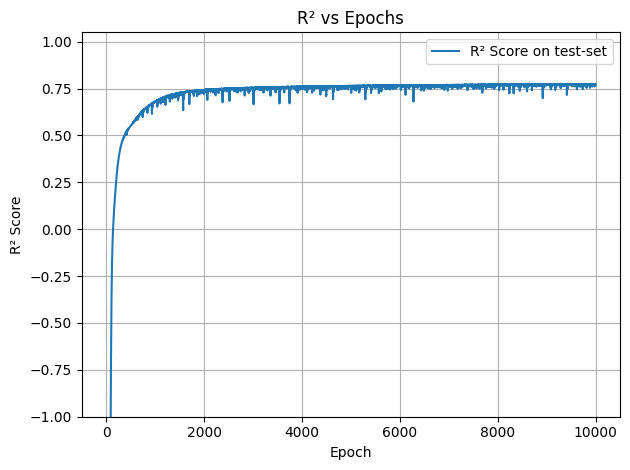

In [10]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

plt.figure()
epochs = list(range(len(r2_test_history)))  # assuming both lists are the same length

# Plotting both curves

plt.plot(epochs, r2_test_history, label="R² Score on test-set")

# Styling
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² vs Epochs")
plt.ylim(-1, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
plot_r2_progress(r2_history)

NameError: name 'plot_r2_progress' is not defined

In [ ]:
# Predict
y_pred = optimizer.model(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import numpy as np

# y_true: your ground truth values
# y_pred: your model's predictions

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    max_err = max_error(y_true, y_pred)

    print(f"📈 Regression Evaluation Metrics")
    print(f"--------------------------------")
    print(f"R² Score         : {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Max Error        : {max_err:.4f}")

In [ ]:
print_regression_metrics(y_test, y_pred)

📈 Regression Evaluation Metrics
--------------------------------
R² Score         : 0.5320
Mean Absolute Error (MAE): 0.9106
Mean Squared Error (MSE): 1.6429
Root Mean Squared Error (RMSE): 1.2818
Max Error        : 14.2904
